<a href="https://colab.research.google.com/github/MohamadHBaydoun/COMP9444/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MohamadHBaydoun/COMP9444.git

Cloning into 'COMP9444'...
remote: Enumerating objects: 3469, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3469 (delta 1), reused 0 (delta 0), pack-reused 3463 (from 1)
Receiving objects: 100% (3469/3469), 2.48 GiB | 39.85 MiB/s, done.
Resolving deltas: 100% (400/400), done.
Updating files: 100% (3835/3835), done.


In [2]:
# 0. Import packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [130]:
# 1. Create model


# USE RESIDUAL NEURAL NETWORKS AND FCN'S WITH 1X1 CONVOLUTIONS AND UPSAMPLING OPERATIONS
import torch

class CustomFCN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(CustomFCN, self).__init__()

        # Downsampling (Encoder)
        self.enc1a = self.conv_chain(in_channels, 3, 3, 8, 1, 1)
        self.enc1 = self.conv_chain(8, 3, 3, 8, 1, 1)
        self.pool1 = nn.MaxPool2d(2, stride=2)

        self.enc2a = self.conv_chain(8, 3, 3, 16, 1, 1)
        self.enc2 = self.conv_chain(16, 3, 3, 16, 1, 1)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.enc3a = self.conv_chain(16, 3, 3, 32, 1, 1)
        self.enc3 = self.conv_chain(32, 3, 3, 32, 1, 1)
        self.pool3 = nn.MaxPool2d(2, stride=2)

       # Upsampling (Decoder)
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv_chain(32, 3, 3, 16, 1, 1)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = self.conv_chain(16, 3, 3, 8, 1, 1)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = nn.Conv2d(in_channels=8, out_channels=out_channels, kernel_size=(1, 1), padding=0, stride=1)

    def conv_chain(self, Din, L, M, D, S, P):
      return nn.Sequential(
          nn.Conv2d(in_channels=Din, out_channels=D, kernel_size=(L, M), padding=P, stride=S),
          nn.ReLU(inplace=True)
      )

    def forward(self, x):
        # Encoder
        #x1 = self.pool1(self.enc1a(x))
        #x2 = self.pool2(self.enc2a(x1))
        #x3 = self.pool3(self.enc3a(x2))
        x1 = self.iterative_forward(x, self.pool1, self.enc1a, self.enc1)
        x2 = self.iterative_forward(x1, self.pool2, self.enc2a, self.enc2)
        x3 = self.iterative_forward(x2, self.pool3, self.enc3a, self.enc3)

        # Decoder
        y = self.up1(x3)
        y = self.dec1(y)
        y = y + x2

        y = self.up2(y)
        y = self.dec2(y)
        y = y + x1

        y = self.up3(y)
        y = self.dec3(y)

        return y

    def iterative_forward(self, x, poolFunc, encFuncA, encFunc):
        # Encoder
        xNew = encFuncA(x)
        for i in range(7):
          xNew = encFunc(xNew)
        return poolFunc(xNew)

# Create model instance
model = CustomFCN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


CustomFCN(
  (enc1a): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc1): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2a): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2,

In [123]:
# 2. Prepare data
IMAGE_PATH = "./COMP9444/filtered_image"
LABEL_PATH = "./COMP9444/filtered_label"

trainFiles = pd.read_csv("./COMP9444/train.csv", header=None)[0].tolist()[:250]
testFiles = pd.read_csv("./COMP9444/test.csv", header=None)[0].tolist()[:250]


def load_image(path, isLabel=False):
    """Load an RGB image and convert to a tensor"""
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((480, 640)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor

    ])
    if isLabel:
      transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((480, 640)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
    ])
      return transform(img).type(torch.float32) # This line is changed
    return transform(img)  # Apply transform

class QuakeCityDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img = load_image(os.path.join(IMAGE_PATH, filename))
        # component = load_annotation("component", filename)
        crack = load_image(os.path.join(LABEL_PATH, "crack", filename), isLabel=True)
        # spall = load_annotation("spall", filename)
        # rebar = load_annotation("rebar", filename)
        # ds = load_annotation("ds", filename)
        # depth = load_annotation("depth", filename)
        label = crack
        return img, label

# Create dataset and dataloader
train_dataset = QuakeCityDataset(trainFiles)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

# Get a batch
img_batch, label_batch = next(iter(train_loader))
print("Batch image shape:", img_batch.shape)
print("Batch label shape:", label_batch.shape)


Batch image shape: torch.Size([10, 3, 480, 640])
Batch label shape: torch.Size([10, 1, 480, 640])


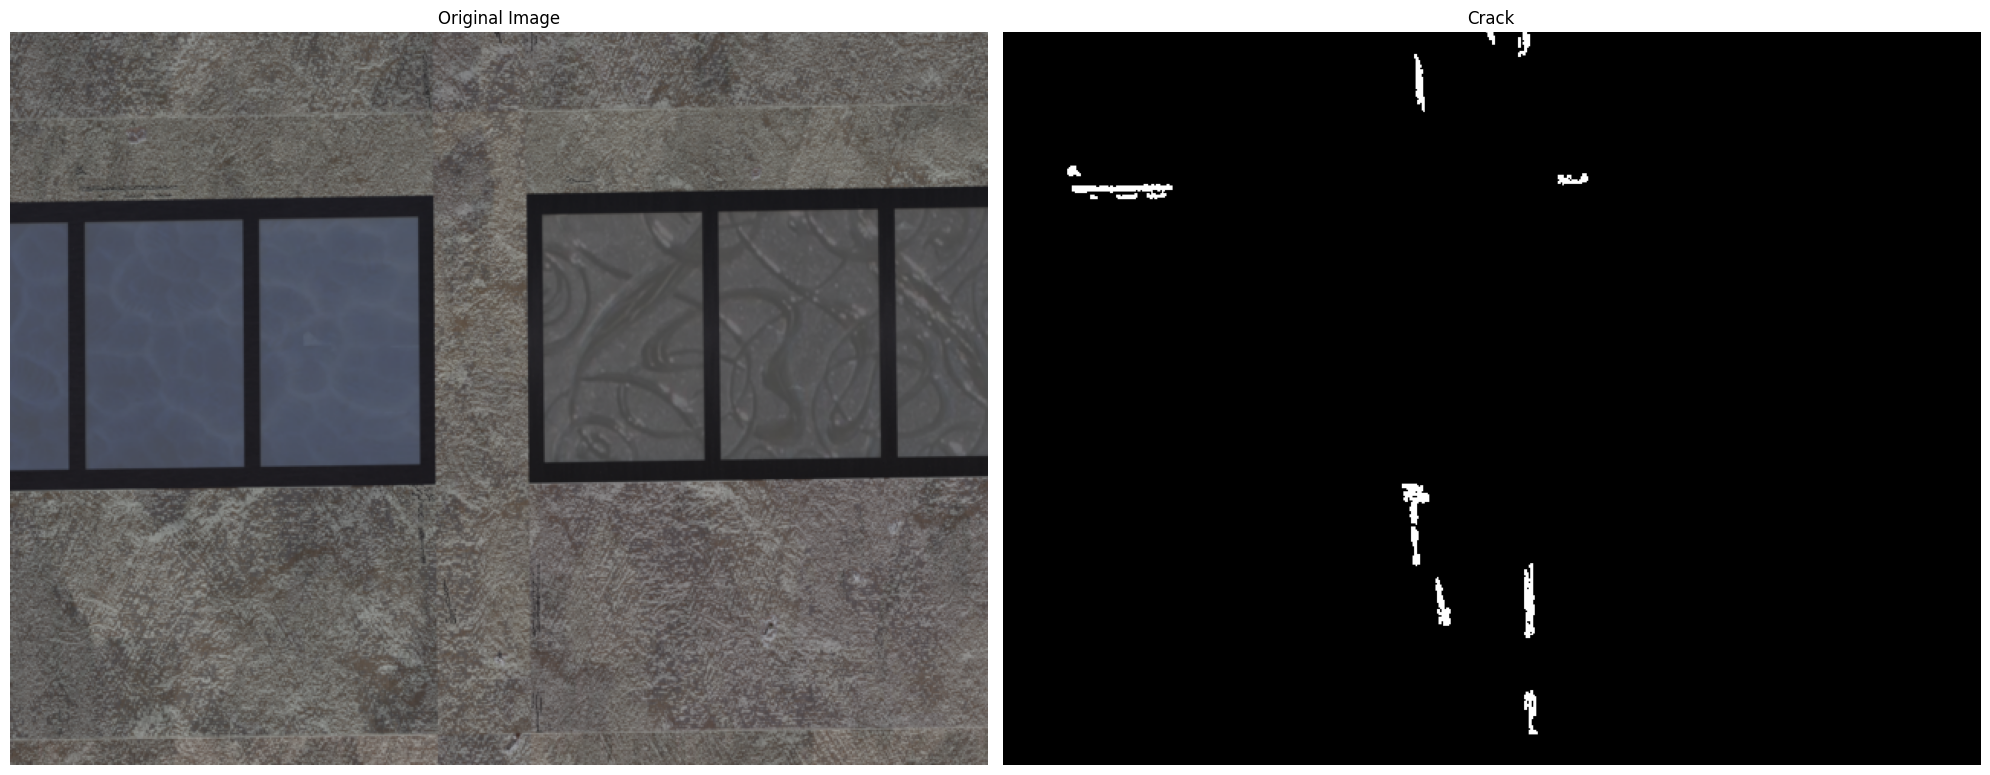

In [110]:
# 2.5 Visualise data
def visualize_sample(image, label):
    """Display the image and its 6 label masks."""
    label_names = ["Component", "Crack", "Spall", "Rebar", "Damage State", "Depth"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Show the original image
    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    # Show the label mask
    axes[1].imshow(label.squeeze(), cmap='gray')  # Visualize label
    axes[1].set_title(label_names[1])
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

img_batch, label_batch = next(iter(train_loader))
visualize_sample(img_batch[0], label_batch[0])

In [146]:
# 3. Choose optimizer

criterion = nn.BCEWithLogitsLoss()  # binary classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)


Epoch  1: zero_grad(): loss=79241245018948388702388224.0000 output_mean=79241245018948388702388224.0000 target_mean= 0.0014


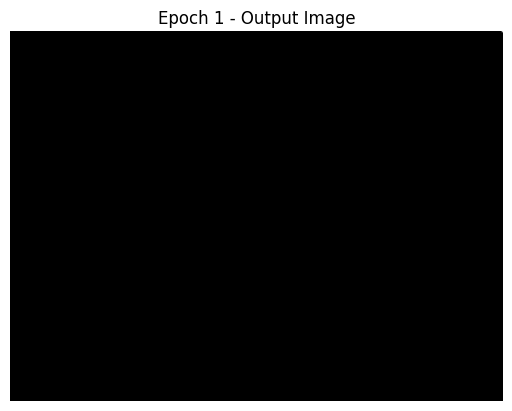

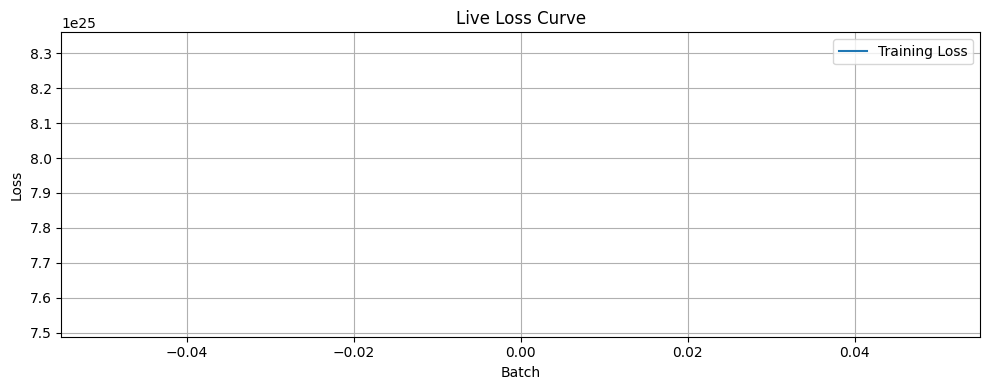

Epoch  1: zero_grad(): loss=72500887744763250234884096.0000 output_mean=72500887744763250234884096.0000 target_mean= 0.0012


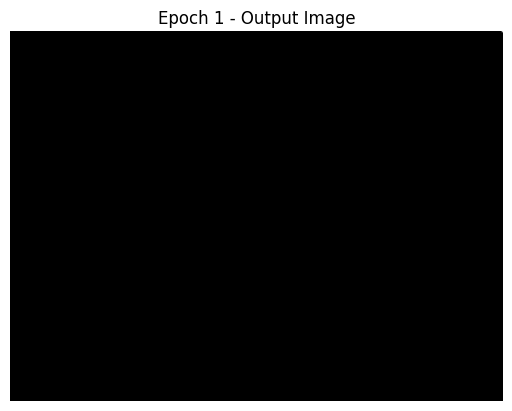

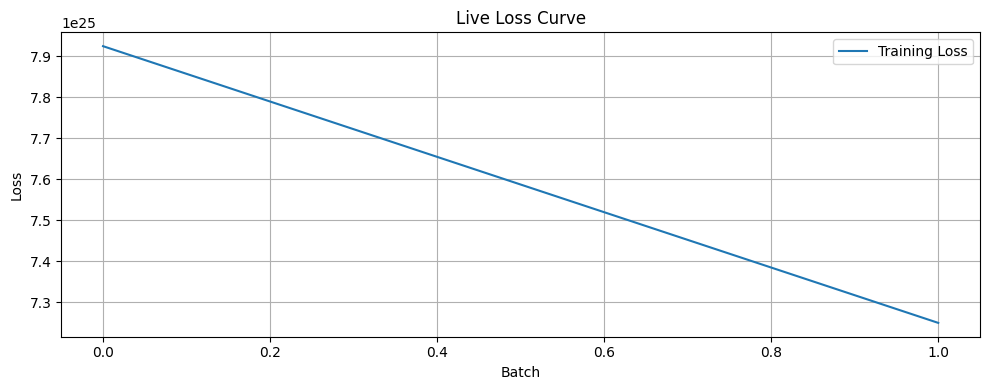

Epoch  1: zero_grad(): loss=65186864400001855276449792.0000 output_mean=65186864400001855276449792.0000 target_mean= 0.0013


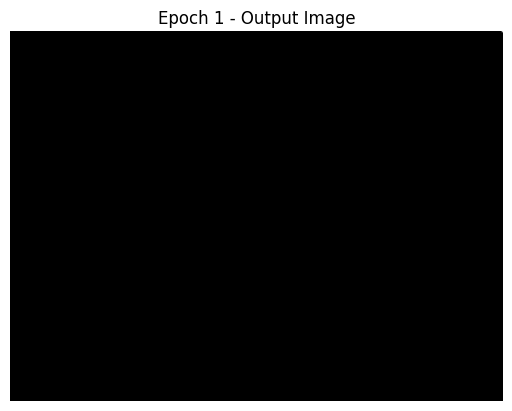

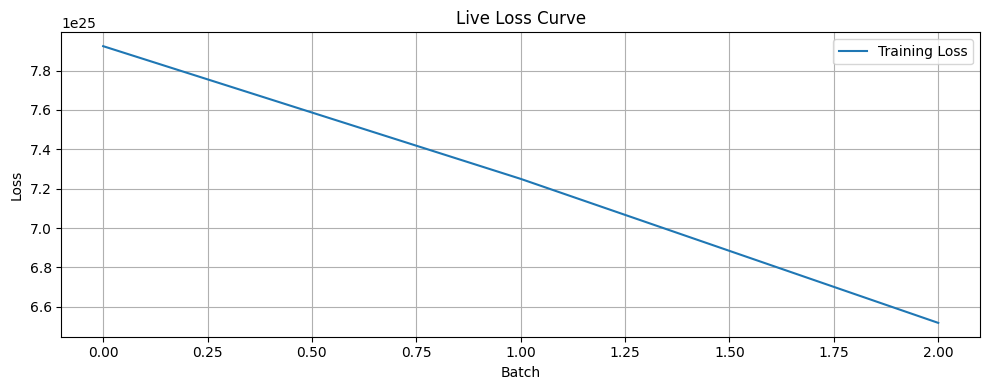

Epoch  1: zero_grad(): loss=67236795728680976618881024.0000 output_mean=67236795728680976618881024.0000 target_mean= 0.0006


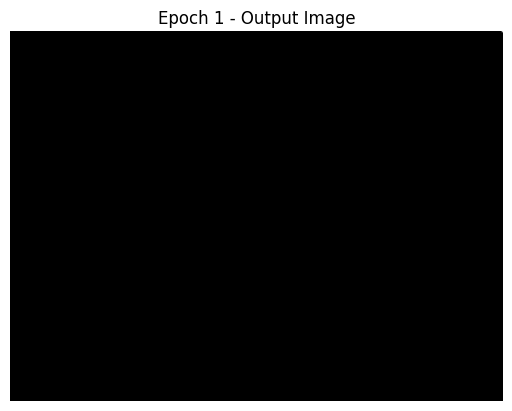

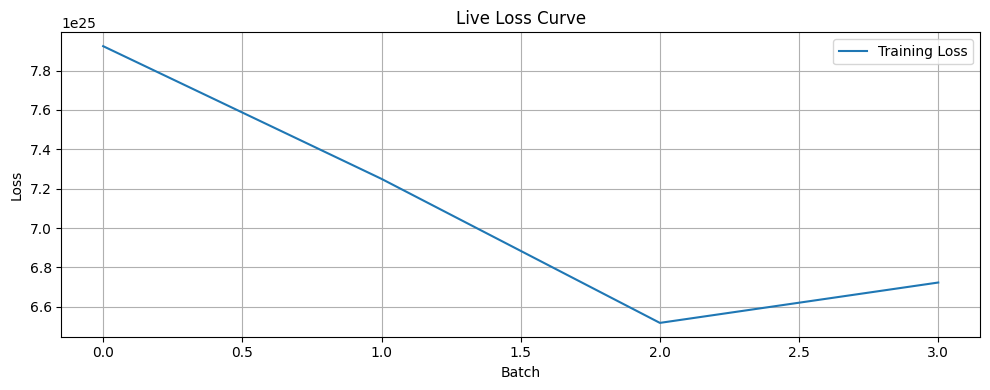

Epoch  1: zero_grad(): loss=70317406600676490166140928.0000 output_mean=70317406600676490166140928.0000 target_mean= 0.0007


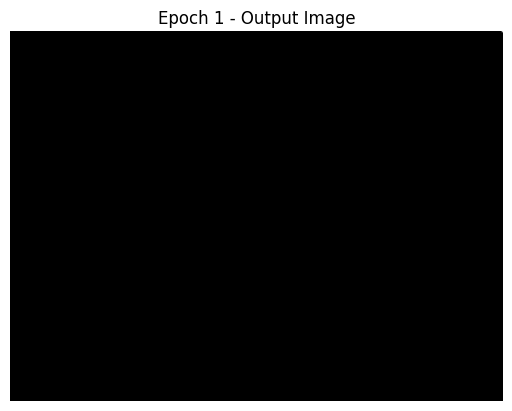

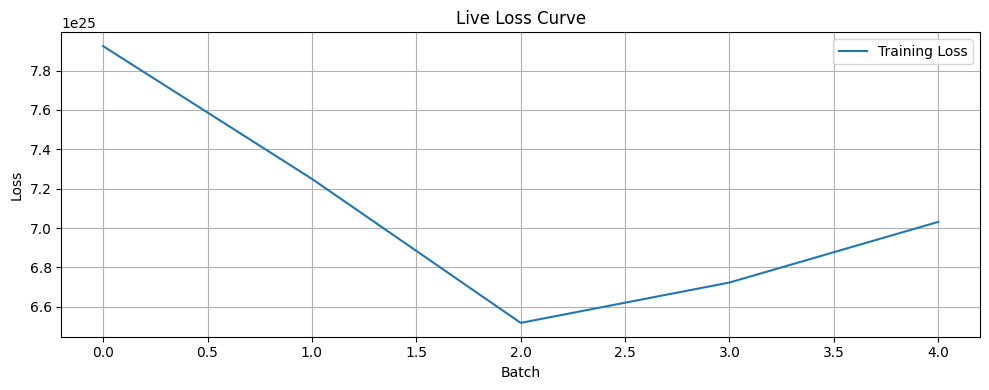

Epoch  1: zero_grad(): loss=82310783232813658091290624.0000 output_mean=82310783232813658091290624.0000 target_mean= 0.0006


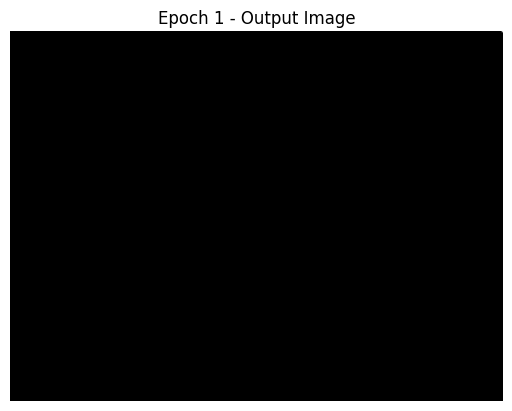

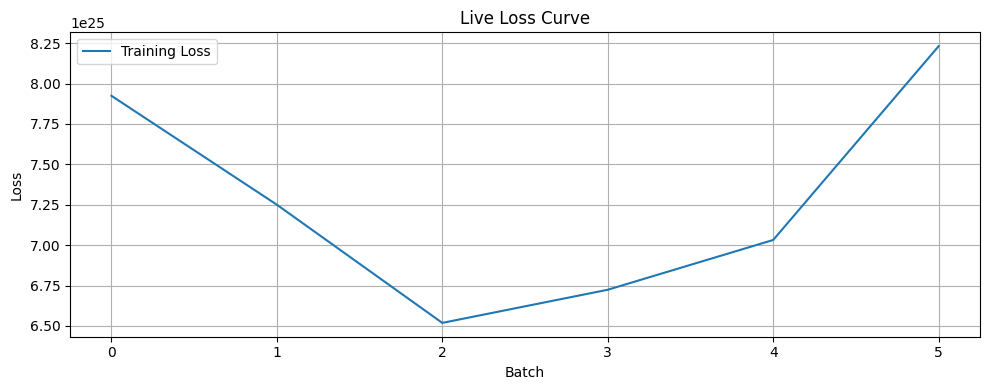

Epoch  1: zero_grad(): loss=73412447438223663010152448.0000 output_mean=73412447438223663010152448.0000 target_mean= 0.0009


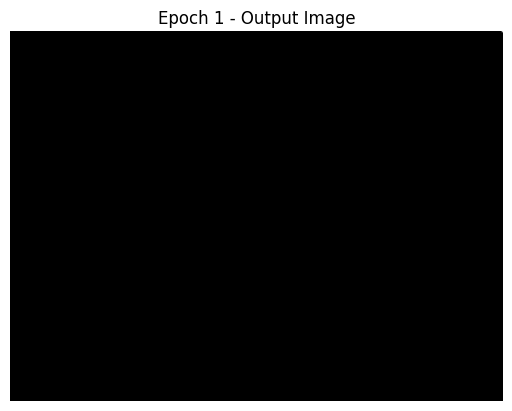

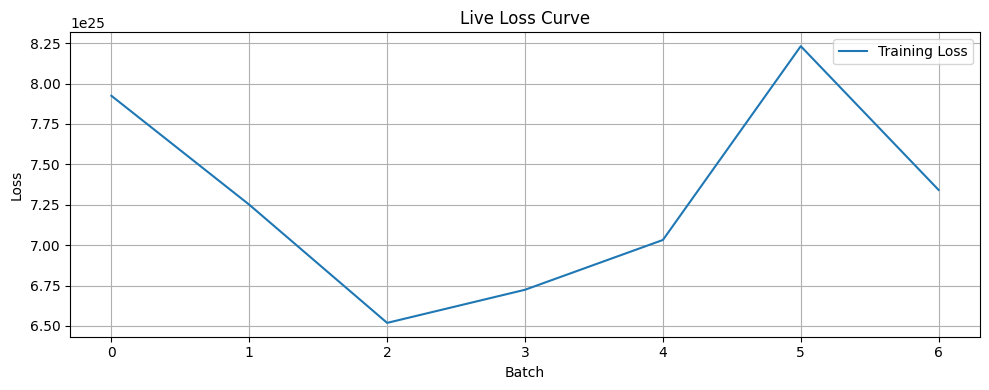

Epoch  1: zero_grad(): loss=68588328715043435909742592.0000 output_mean=68588328715043435909742592.0000 target_mean= 0.0013


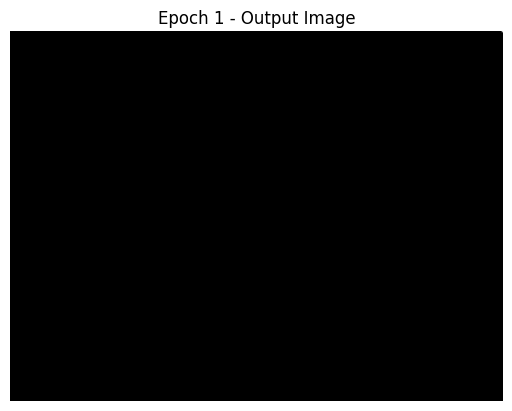

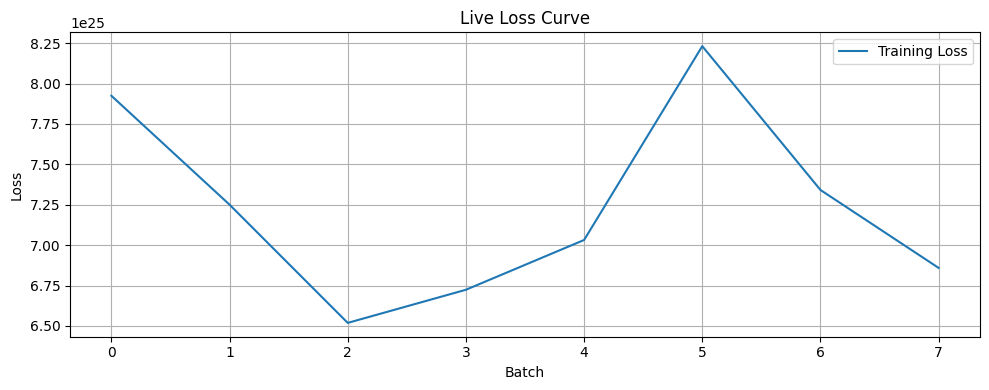

Epoch  1: zero_grad(): loss=90301571500779272224636928.0000 output_mean=90301571500779272224636928.0000 target_mean= 0.0006


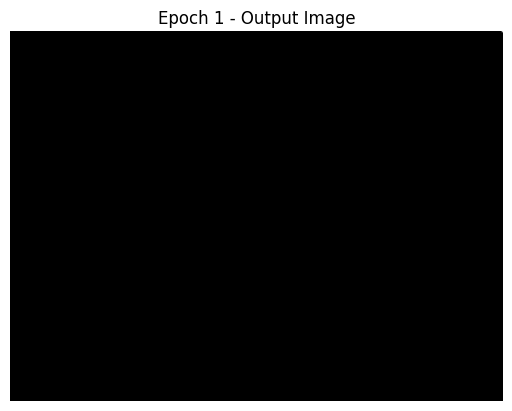

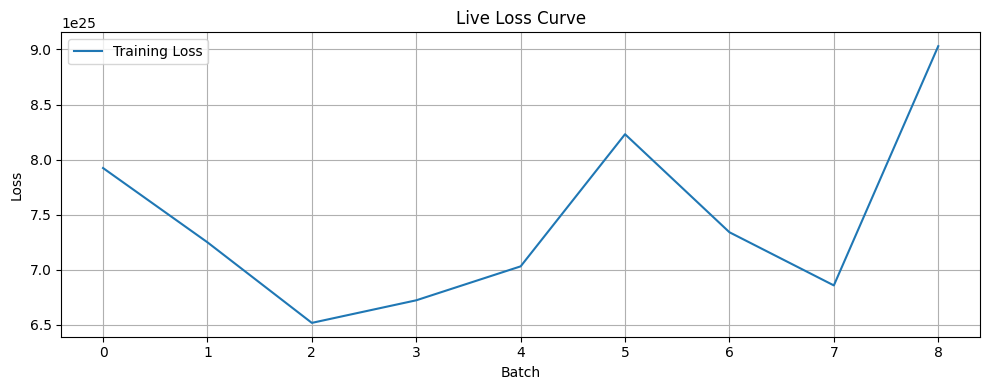

Epoch  1: zero_grad(): loss=76090384333834170755186688.0000 output_mean=76090384333834170755186688.0000 target_mean= 0.0007


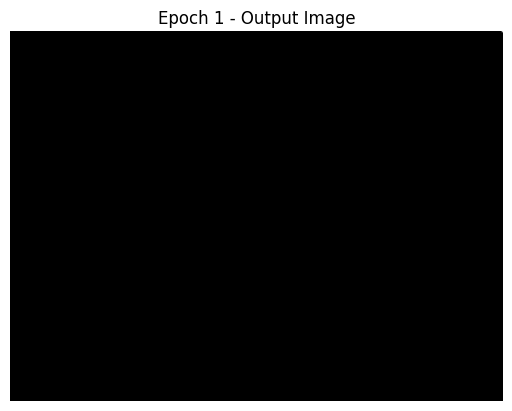

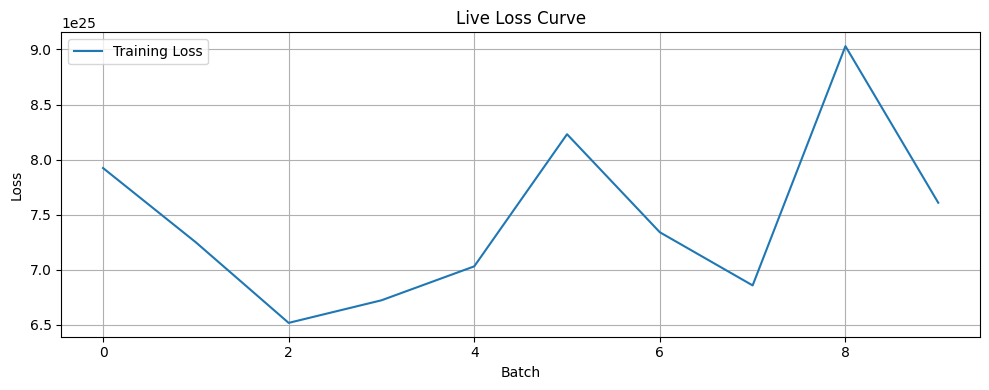

Epoch  1: zero_grad(): loss=70838374935120176895492096.0000 output_mean=70838374935120176895492096.0000 target_mean= 0.0008


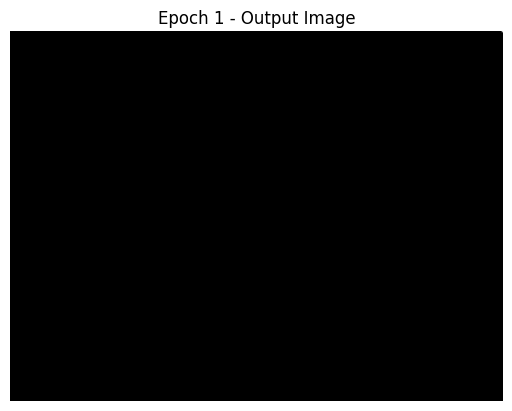

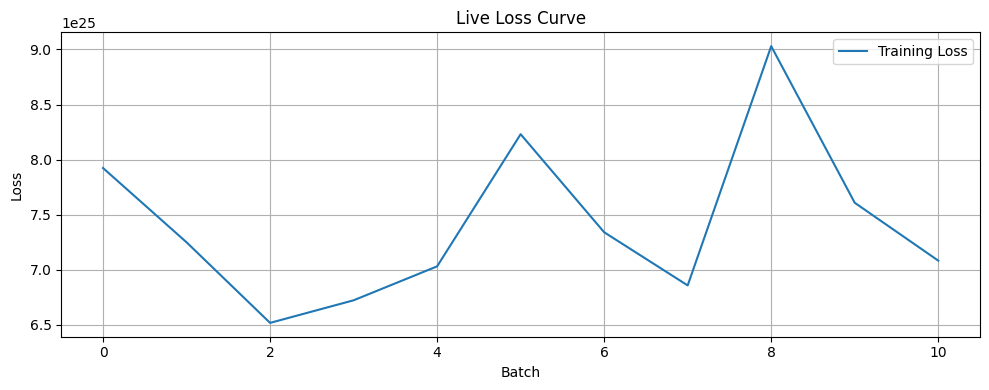

Epoch  1: zero_grad(): loss=69786421684200779150262272.0000 output_mean=69786421684200779150262272.0000 target_mean= 0.0012


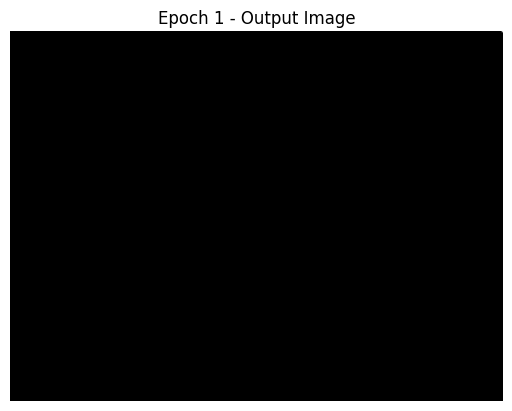

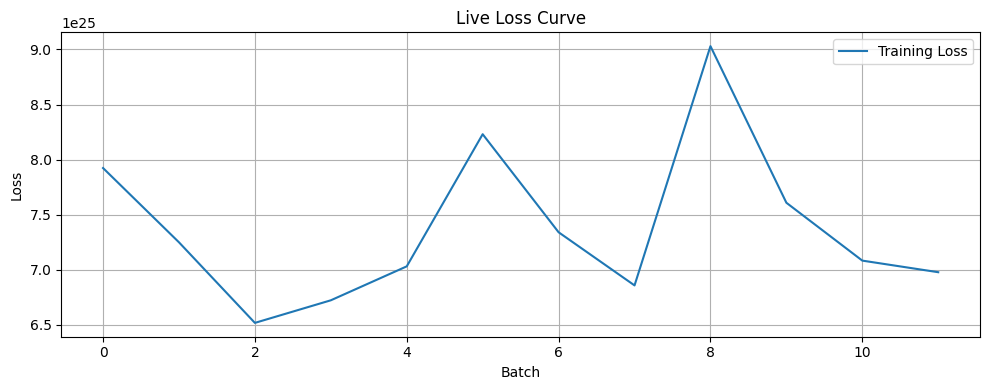

In [ ]:
import matplotlib.pyplot as plt

losses = []
epochs = 100

for epoch in range(1, epochs):
    for batch_id, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        # Save and print loss
        losses.append(loss.item())
        print('Epoch%3d: zero_grad(): loss=%7.4f output_mean=%7.4f target_mean=%7.4f' %
              (epoch, loss.item(), output.mean().item(), target.mean().item()))


        # Optional: show output image too
        output_image = output[-1].cpu().detach().numpy()
        plt.imshow(output_image.squeeze(), cmap='gray')
        plt.title(f"Epoch {epoch} - Output Image")
        plt.axis('off')
        plt.show()

                # Plot live loss curve
        plt.figure(figsize=(10, 4))
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Live Loss Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



In [26]:
!pip install --upgrade torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

F1 Score: 0.0
Confusion matrix, without normalization
[[76800000        0]
 [       0        0]]


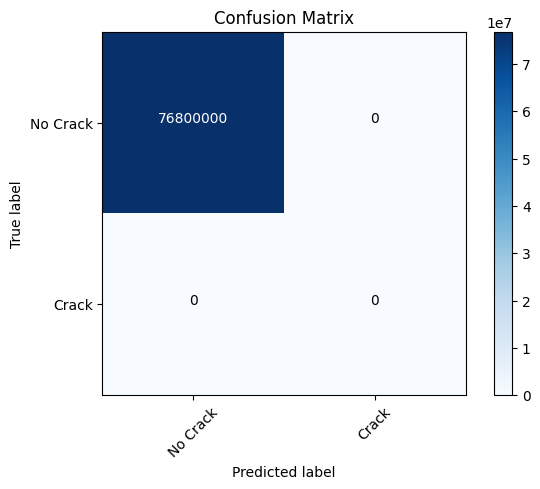

In [68]:
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np

def calculate_f1_and_confusion_matrix(model, dataloader, device):
    """
    Calculates the F1 score and confusion matrix for a given model and dataloader.

    Args:
        model: The trained PyTorch model.
        dataloader: The DataLoader for the dataset.
        device: The device (CPU or GPU) to use.

    Returns:
        f1_score: The calculated F1 score.
        confusion_matrix: The confusion matrix as a NumPy array.
    """

    # Initialize metrics
    f1 = torchmetrics.F1Score(task="binary", num_classes=2).to(device) # Assuming binary classification
    confusion_matrix = torchmetrics.ConfusionMatrix(task="binary", num_classes=2).to(device)

    # Iterate over the dataloader
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Apply sigmoid to get probabilities (if using BCEWithLogitsLoss)
            output = torch.sigmoid(output)

            # Threshold predictions to get binary values
            predicted_labels = (output > 0.5).int()

            # Update metrics
            f1.update(predicted_labels, target.int())
            confusion_matrix.update(predicted_labels, target.int())

    # Compute and return the final metrics
    f1_score = f1.compute().item()
    confusion_matrix = confusion_matrix.compute().cpu().numpy()

    return f1_score, confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.

    Args:
        cm: The confusion matrix as a NumPy array.
        classes: A list of class names.
        normalize: If True, normalize the confusion matrix.
        title: The title of the plot.
        cmap: The colormap to use.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Calculate and display F1 score and confusion matrix
f1_score, confusion_matrix = calculate_f1_and_confusion_matrix(model, train_loader, device)
print(f"F1 Score: {f1_score}")

# Plot the confusion matrix
class_names = ['No Crack', 'Crack']  # Replace with your class names
plot_confusion_matrix(confusion_matrix, classes=class_names, title='Confusion Matrix')